In [1]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import numpy as np

In [2]:
query = """
WITH candidato as (
  SELECT sigla_uf, 
          INITCAP(raca) as raca, 
          COUNT(ano) as n_candidato
  FROM `basedosdados.br_tse_eleicoes.candidatos`
  WHERE ano = 2022
  GROUP BY 1,2
), 

populacao as (
  SELECT sigla as sigla_uf,regiao, raca_cor as raca, SUM(populacao) as populacao 
  FROM `basedosdados.br_ibge_pnadc.ano_uf_raca_cor` as t1
  LEFT JOIN `basedosdados.br_bd_diretorios_brasil.uf` as t2
  ON t1.id_uf = t2.id_uf
  WHERE ano = 2019
  AND sexo = 'Total'
  AND raca_cor != 'Total'
  GROUP BY 1,2,3
)

SELECT 
  t2.sigla_uf,
  t3.regiao,
  t2.raca,
  populacao*100 / SUM(populacao) OVER (PARTITION BY t2.sigla_uf) as porcentagem_populacao,
  n_candidato*100 / SUM(n_candidato) OVER (PARTITION BY t2.sigla_uf) as porcentagem_candidato
FROM candidato as t2
LEFT JOIN populacao as t1
ON t1.sigla_uf = t2.sigla_uf AND t1.raca=t2.raca
LEFT JOIN `basedosdados.br_bd_diretorios_brasil.uf` as t3
ON t1.sigla_uf = t3.sigla
"""
df_candidatos = bd.read_sql(query, billing_project_id="rfid-250503")

Downloading: 100%|████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 425.90rows/s]


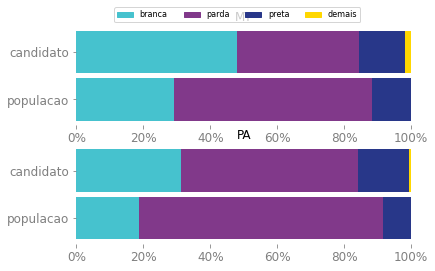

In [23]:
fig, ax = plt.subplots(2,1, figsize=(6,4))
## AJUSTES DA IMAGEM

#apaga os contornos da imagem
#vetor das cores que vamos usar
colors = ['#46C2CE', '#81398A', '#283789', 'gold']

#cria legenda
brancos = mpatches.Patch(color=colors[0], label='branca')
pardos = mpatches.Patch(color=colors[1], label='parda')
pretos = mpatches.Patch(color=colors[2], label='preta')
amarelos_vermelhos = mpatches.Patch(color=colors[3], label='demais')
i=0

#ajusta parametros da legenda
ax[0].legend(handles=[brancos, pardos, pretos, amarelos_vermelhos],
          ncol=4,
          bbox_to_anchor=(0.1, 1),
          fontsize=8)


for sigla_uf in ['MT','PA']:
    #apaga os contornos da imagem
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    #ajusta para que os números fiquem no formato percentual
    ax[i].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

    #deixa os marcadores numa cor mais suave que o preto
    ax[i].tick_params(axis='y', colors='gray')
    ax[i].tick_params(axis='x', colors='gray')

    #aumenta o tamanho da letra pra que fique mais visível
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].tick_params(axis='both', which='minor', labelsize=12)
    uf = df_candidatos['sigla_uf'] == sigla_uf
    
    ax[i].set_title(sigla_uf)
    brancos = df_candidatos['raca'] == 'Branca'
    p1 = ax[i].barh(y='populacao',
                  height=0.9,
                  width=df_candidatos['porcentagem_populacao'][uf&brancos].values,
                  color=colors[0])
    lefts = df_candidatos['porcentagem_populacao'][uf&brancos].values
    
    
    pardos = df_candidatos['raca'] == 'Parda'
    p2 = ax[i].barh(y='populacao',
                  height=0.9,
                  width=df_candidatos['porcentagem_populacao'][uf&pardos].values,
                  color=colors[1], 
                  left = lefts)
    lefts = lefts + df_candidatos['porcentagem_populacao'][uf&pardos].values


    pretos = df_candidatos['raca'] == 'Preta'

    p3 = ax[i].barh(y='populacao',
                  height=0.9,
                  width=df_candidatos['porcentagem_populacao'][uf&pretos].values,
                  color=colors[2], 
                  left = lefts)
    lefts = lefts + df_candidatos['porcentagem_populacao'][uf&pretos].values

    outros = ~df_candidatos['raca'].isin(['Preta','Parda','Branca'])
    p4 = ax[i].barh(y='populacao',
                  height=0.9,
                  width=df_candidatos['porcentagem_populacao'][uf&outros].values,
                  color=colors[3], 
                  left = lefts)

    brancos = df_candidatos['raca'] == 'Branca'
    p1 = ax[i].barh(y='candidato',
                  height=0.9,
                  width=df_candidatos['porcentagem_candidato'][uf&brancos].values,
                  color=colors[0])
    lefts = df_candidatos['porcentagem_candidato'][uf&brancos].values
    
    
    pardos = df_candidatos['raca'] == 'Parda'
    p2 = ax[i].barh(y='candidato',
                  height=0.9,
                  width=df_candidatos['porcentagem_candidato'][uf&pardos].values,
                  color=colors[1], 
                  left = lefts)
    lefts = lefts + df_candidatos['porcentagem_candidato'][uf&pardos].values

    
    pretos = df_candidatos['raca'] == 'Preta'

    p3 = ax[i].barh(y='candidato',
                  height=0.9,
                  width=df_candidatos['porcentagem_candidato'][uf&pretos].values,
                  color=colors[2], 
                  left = lefts)
    lefts = lefts + df_candidatos['porcentagem_candidato'][uf&pretos].values

    outros = ~df_candidatos['raca'].isin(['Preta','Parda','Branca'])
    p4 = ax[i].barh(y='candidato',
                  height=0.9,
                  width=sum(df_candidatos['porcentagem_candidato'][uf&outros].values),
                  color=colors[3], 
                  left = lefts)
    i=i+1
    
plt.savefig("para.svg")